In [91]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import anndata
import math
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import splrep, BSpline
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 10

In [2]:
adata = anndata.read_h5ad("C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

In [3]:
# set your gene of interest (GOI) here:

GOI = "JCHAIN"
cell_type = 'Plasma'

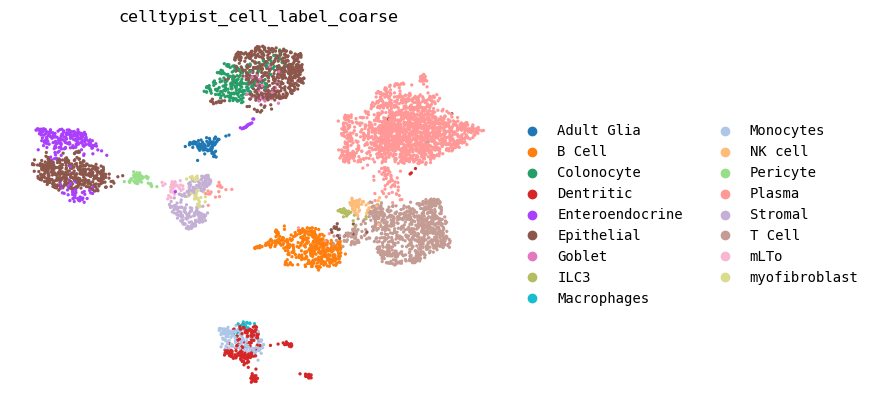

In [4]:
sc.pl.umap(
    adata,    color=["celltypist_cell_label_coarse"],
    frameon=False,
)

In [5]:
def clean_data(df, col, threshold = 99.75):
    data = df[col].to_numpy().flatten()
    data = data[data <= np.percentile(data, threshold)]
    return data

def find_thresholds(filtered):
    range = (abs(max(filtered)) + abs(min(filtered)))
    step = range / float(4)
    very_low = min(filtered) + step
    low = min(filtered) + step*2
    middle = min(filtered) + step*3
    #print(round(very_low, 2), round(low, 2), round(middle, 2), round(max(filtered), 2))
    return very_low, low, middle, max(filtered)

def classify_exp_level(df, filtered, col, print_quantile = False, print_gene_num = False):
    very_low, low, middle, high = find_thresholds(filtered)
    def func(x):
        if x <= very_low:
            return "very_low"
        elif very_low < x <= low:
            return "low"
        elif low < x <= middle:
            return "middle"
        elif middle < x <= high:
            return "high"
        else:
            return "very_high"
    df['expr_class'] = df[col].apply(func)
    if print_quantile:
        print(str(round(stats.percentileofscore(df[col], very_low), 4)) + ", " + str(round(stats.percentileofscore(df[col], low), 4)) + ", " + 
              str(round(stats.percentileofscore(df[col], middle), 4)) + ", " + str(round(stats.percentileofscore(df[col], high), 4)) + ", 99.7500")
    if print_gene_num:
        print("Number of genes per category: ")
        print("very_low: " + str(len(df[df['expr_class'] == 'very_low'])))
        print("low: " + str(len(df[df['expr_class'] == 'low'])))
        print("middle: " + str(len(df[df['expr_class'] == 'middle'])))
        print("high: " + str(len(df[df['expr_class'] == 'high'])))
        print("very_high: " + str(len(df[df['expr_class'] == 'very_high'])))
    return df

def make_df(adata, col='log1p(means)', layer='log_norm', print_quantile=False, print_gene_num=False):
    sc.pp.highly_variable_genes(adata, layer=layer)
    df = adata.var.sort_values(['means'])
    df['gene_num'] = range(len(df))
    df['log(means)'] = np.log(df['means'])
    df['log1p(means)'] = np.log1p(df['means'])

    filtered = clean_data(df, col=col, threshold=99.75) # can choose upper outlier threshold here
    df_new = classify_exp_level(df =df, filtered=filtered, col=col, print_quantile=print_quantile, print_gene_num = print_gene_num)
    return df_new

In [6]:
def explain_expr_celltypes(adata, col='log1p(means)', layer='log_norm', print_quantile=False, print_gene_num=False):
    print(GOI + " Expression across cell types: ")
    print("\t [cell type]; [expression classification]; [avg. expression over this cell type]")
    for cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
        subset = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        df = make_df(subset, col)
        print("\t " + cell_type + ";  " + str(df.loc[df.index == GOI]['expr_class'].values[0]) + ";  " + str(round(df.loc[df.index == GOI][col].values[0], 3)))

In [7]:
explain_expr_celltypes(adata)

JCHAIN Expression across cell types: 
	 [cell type]; [expression classification]; [avg. expression over this cell type]
	 mLTo;  middle;  0.877
	 Monocytes;  very_low;  0.264
	 B Cell;  low;  0.593
	 Epithelial;  middle;  0.81
	 T Cell;  low;  0.542
	 Dentritic;  middle;  0.973
	 Plasma;  very_high;  1.889
	 Enteroendocrine;  very_low;  0.143
	 Colonocyte;  low;  0.729
	 myofibroblast;  very_low;  0.125
	 Stromal;  very_low;  0.342
	 Adult Glia;  high;  1.036
	 Pericyte;  low;  0.398
	 ILC3;  very_low;  0.138
	 NK cell;  middle;  1.01
	 Macrophages;  very_low;  0.112
	 Goblet;  high;  1.264


In [ ]:
# TODO threshold for expectring dropout zeros 

def dropout_threshold(adata):
    df = adata.to_df()
    # finalized threshold to come here
    return df

In [8]:
# find overall expression of all genes, highlighting GOI

def plot_expr_class(adata, cell_type=None, col='log1p(means)', print_quantile=True, print_gene_num = True):
    title = "Overall expression across all cell types"
    if cell_type != None:
        title = str("Overall expression in " + cell_type + " cells")
        if cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
            adata = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        elif cell_type in adata.obs['celltypist_cell_label'].unique():
            adata = adata[adata.obs['celltypist_cell_label'] == cell_type]
        else:
            print("Cell type not found. Please check spelling.")
            return
    
    df_new = make_df(adata, print_quantile=print_quantile, print_gene_num = print_gene_num)

    g = sns.scatterplot(data=df_new, x='gene_num',  y=col, hue='expr_class', linewidth=0)
    annotation = str(GOI + " (" + df_new.loc[df_new.index == GOI]['expr_class'].values[0] + ")")
    highlight_y = df_new.loc[df_new.index == GOI][col]
    highlight_x = df_new.loc[df_new.index == GOI]['gene_num']
    g.scatter(highlight_x, highlight_y, color = 'yellow', linewidth=1)
    props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
    g.annotate(annotation, (highlight_x, highlight_y), (highlight_x - 1000, highlight_y+0.7), arrowprops=props, ha='right') #TODO make arrow go down if gene is very high on
    g.set_title(title)
    g.set_xlabel("ranked genes")
    g.set_ylabel("log1p(mean expression)")
    plt.show()

90.8188, 97.769, 99.0909, 99.7488, 99.7500
Number of genes per category: 
very_low: 15184
low: 1162
middle: 221
high: 110
very_high: 42


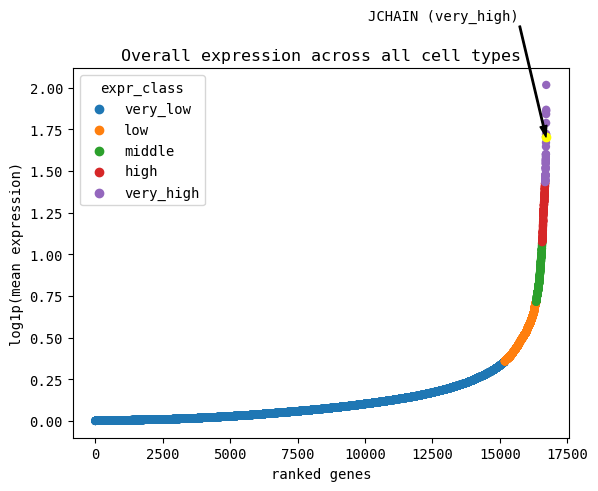

In [9]:
plot_expr_class(adata)

90.2805, 97.5298, 99.1208, 99.7488, 99.7500
Number of genes per category: 
very_low: 15094
low: 1212
middle: 266
high: 105
very_high: 42


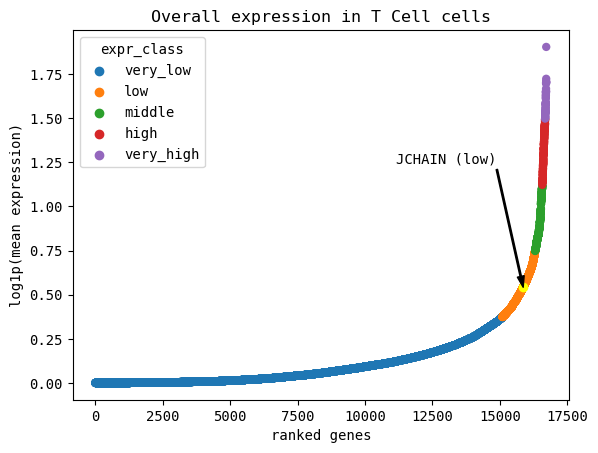

In [9]:
# find overall expression of all genes within cell type of interest, highlighting GOI

plot_expr_class(adata, cell_type='T Cell')

In [10]:
plt.rcParams["font.size"] = 11

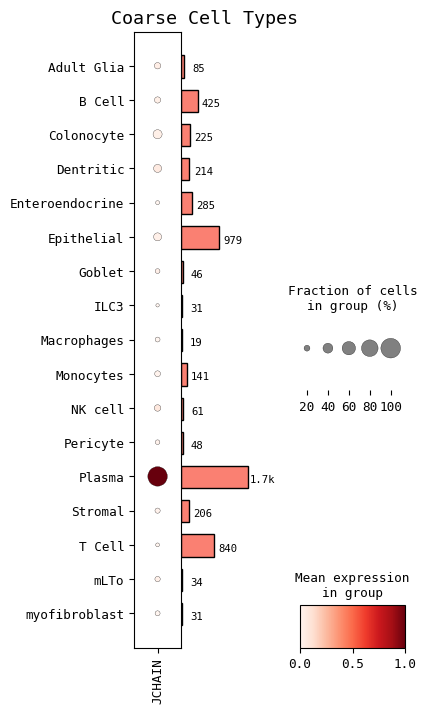

In [11]:
# find expression across cell types of GOI here

markers= GOI
ax1 = sc.pl.dotplot(adata, var_names=markers, groupby='celltypist_cell_label_coarse', 
                    return_fig=True, standard_scale='var', title="Coarse Cell Types", figsize=(3.5,8))
ax1.add_totals().show()

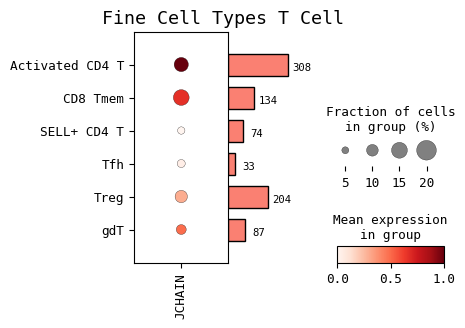

In [12]:
# TODO: make interactive: click on cell type to see fine cell types
cell_type = 'T Cell'

ax1 = sc.pl.dotplot(adata[adata.obs['celltypist_cell_label_coarse'] == cell_type], var_names=markers, groupby='celltypist_cell_label', 
                    return_fig=True, standard_scale='var', title=str('Fine Cell Types ' + cell_type), figsize=(4,3))
ax1.add_totals().show()

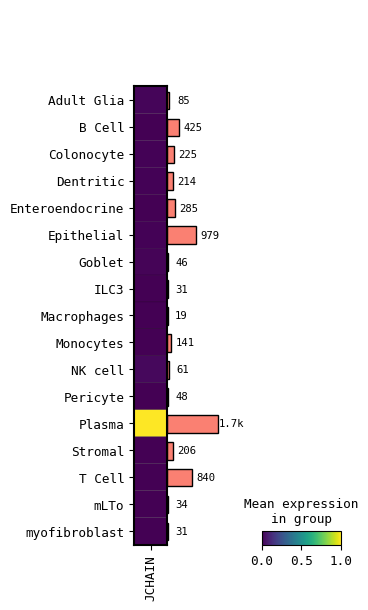

In [13]:
ax2 = sc.pl.matrixplot(adata, markers, groupby='celltypist_cell_label_coarse', return_fig=True, layer='log_int_norm', standard_scale='var')
ax2.add_totals().style(edge_color='black').show()

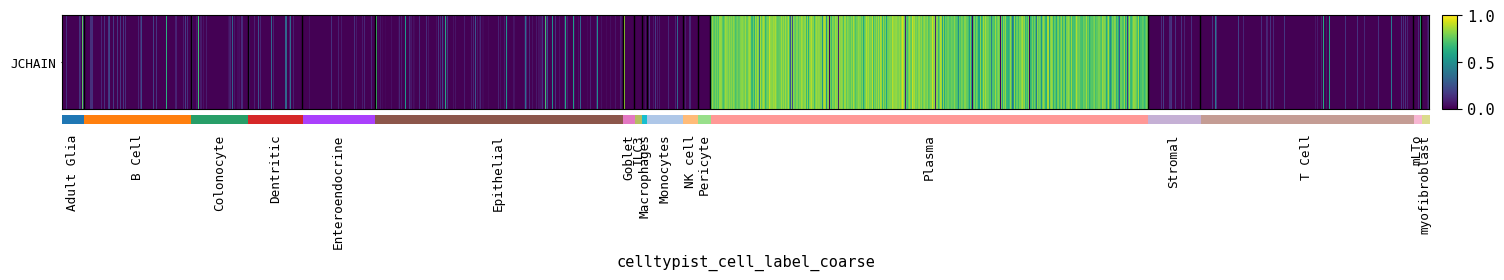

In [14]:
sc.pl.heatmap(adata, markers, groupby='celltypist_cell_label_coarse', swap_axes=True, figsize=(18,1.5), layer='log_norm', standard_scale='var')

In [15]:
def plot_per_cell_type(adata, cell_type, layer='log_norm'):
        data = adata[:, GOI]
        df = data.to_df(layer=layer)
        df['cell_type'] = data.obs['celltypist_cell_label_coarse']
        df['sample'] = data.obs['sampleID']

        df_cell = df[df['cell_type'] == cell_type]
        df_cell['cell_type'] = df_cell['cell_type'].cat.remove_unused_categories()

        # Create a catplot with box plots, small space between boxes
        plot = sns.catplot(data=df_cell, x='cell_type', y=GOI, hue='sample', kind='box', height=5, aspect=0.999)

        # Adjust the figure layout
        plot.fig.subplots_adjust(top=0.9)
        plot.fig.suptitle(str(GOI) + " Expression Across " + cell_type)

        # Calculate non-zero counts per sample
        non_zero_counts_per_sample = df_cell.groupby('sample')[GOI].apply(lambda x: (x != 0).sum())

        # Add legend with hue color and non-zero counts per sample
        handles, labels = plot._legend_data.values(), non_zero_counts_per_sample.values
        plot.ax.legend(handles, labels, title='Non-zero Counts', loc='lower left', bbox_to_anchor=(1, 0.7))

        # Show the plot
        plt.show()

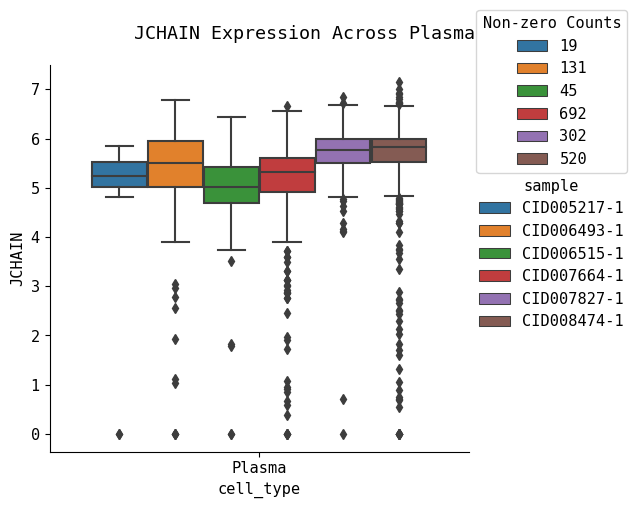

In [16]:
# GOI expression across samples (patients) with extra info on non-zero counts per patient
plot_per_cell_type(adata, cell_type='Plasma')

In [16]:
# for cell type: mean expression of a gene (x) vs. percentace of cells where this gene is detected (y) (wihtin a cell type)

def pl_expression_vs_detection(adata, cell_type=None, layer='log_norm', col='log1p(means)', ax=None, return_df = False):
    
    title=str(GOI)
    if cell_type != None:
        title = str("Overall expression in " + cell_type + " cells")
        if cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
            adata = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        elif cell_type in adata.obs['celltypist_cell_label'].unique():
            adata = adata[adata.obs['celltypist_cell_label'] == cell_type]
        else:
            print("Cell type not found. Please check spelling.")
            return
    else:
        title = "All cell types"
        
    df = make_df(adata, col, layer=layer)

    # calculate percentage of cells (of the given cell type) where each gene is detected
    subset_df = adata.to_df(layer=layer)
    #nonzero_detected = pd.DataFrame(subset_df.astype(bool).sum(axis=0) / len(df) * 100, columns=['percent_detected'])
    nonzero_detected = pd.DataFrame(np.count_nonzero(subset_df, axis=0) / len(subset_df)*100, columns=['percent_detected'], index=subset_df.columns)
    df = df.join(nonzero_detected, how='left').sort_values(['gene_num'], ascending=True)
    if return_df:
        return df
        
    # plot mean expression of a gene (x) vs. percentage of cells where this gene is detected (y)
    ax = sns.scatterplot(data=df, x=col, y='percent_detected', hue='expr_class', linewidth=0)
    ax.set_title(str(title+ ": mean expression vs. percentage detected"))
    ax.legend(title='Expression Class', loc='lower left', bbox_to_anchor=(1, 0))

    annotation = str(GOI)
    highlight_y = df.loc[df.index == GOI]['percent_detected']
    highlight_x = df.loc[df.index == GOI][col]
    ax.scatter(highlight_x, highlight_y, color = 'yellow', linewidth=1)
    props = dict(facecolor='black', width=1, headwidth=5, headlength=8)
    ax.annotate(annotation, (highlight_x, highlight_y), (highlight_x-0.1, highlight_y+20), arrowprops=props)
    plt.show()
    return ax


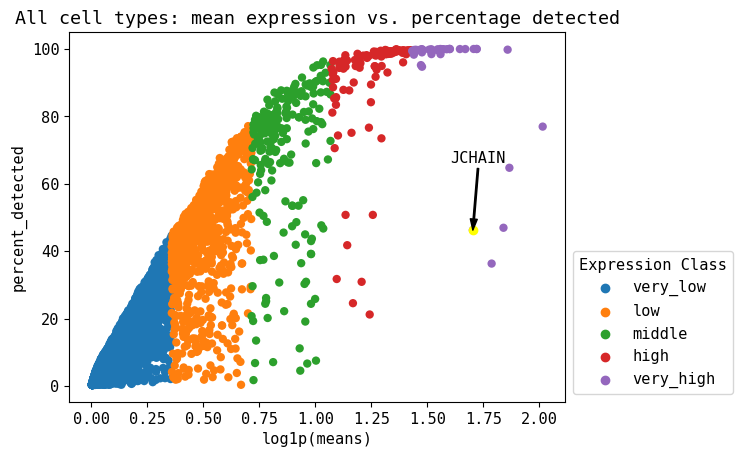

<AxesSubplot: title={'center': 'All cell types: mean expression vs. percentage detected'}, xlabel='log1p(means)', ylabel='percent_detected'>

In [17]:
pl_expression_vs_detection(adata)
# very interesting!! 

### Fit curve to the max curve seen above to calculate threshold for lower genes, curve turning point, etc. 

In [127]:
# make bins and take maximum of each bin to get (x,y) points to fit sigmoid curve to
df = pl_expression_vs_detection(adata, return_df=True)
df['percent_detected'] = df['percent_detected']/100
df_bins = df.groupby(pd.cut(df['log1p(means)'], np.arange(0, max(df['log1p(means)']), 0.05))).max() 
#TODO issue here that the log1p(means) value is also always the max, as in the very top of the bin instead of the median for example? 
df_bins = df_bins.dropna()
df_bins.tail()

,n_cells,highly_variable,means,dispersions,dispersions_norm,gene_num,log(means),log1p(means),expr_class,percent_detected
log1p(means),,,,,,,,,,
"(1.65, 1.7]",5395.0,0.0,4.310972,3.437926,-0.515658,16709.0,1.461163,1.669775,very_high,0.999629
"(1.7, 1.75]",5397.0,0.0,4.589110,5.569919,1.152576,16713.0,1.523686,1.720820,very_high,1.000000
"(1.75, 1.8]",1962.0,0.0,4.974173,8.053759,1.000000,16714.0,1.604259,1.787446,very_high,0.363535
"(1.8, 1.85]",2535.0,0.0,5.298882,8.070549,0.950056,16715.0,1.667496,1.840372,very_high,0.469705
"(1.85, 1.9]",5385.0,0.0,5.467296,6.664341,0.093343,16717.0,1.698784,1.866758,very_high,0.997777


In [128]:
def sigmoid(x, a):
    return (2 / (1 + math.e**((-a)*x)) - 1)

# fit function here
xdata = df_bins['log1p(means)']
ydata = df_bins['percent_detected']
for bin, value in ydata.items():
    if (bin.right > 1.25) and (value < 0.7):
        ydata.loc[bin] = 0.999
popt, pcov = curve_fit(sigmoid, xdata, ydata)
ydata.tail()

log1p(means)
(1.65, 1.7]    0.999629
(1.7, 1.75]    1.000000
(1.75, 1.8]    0.999000
(1.8, 1.85]    0.999000
(1.85, 1.9]    0.997777
Name: percent_detected, dtype: float64

In [121]:
def calc_y(x, a, func=sigmoid):
    out = []
    for xi in x:
        out.append(func(xi, a))
    return out

func_y = calc_y(xdata, popt[0])

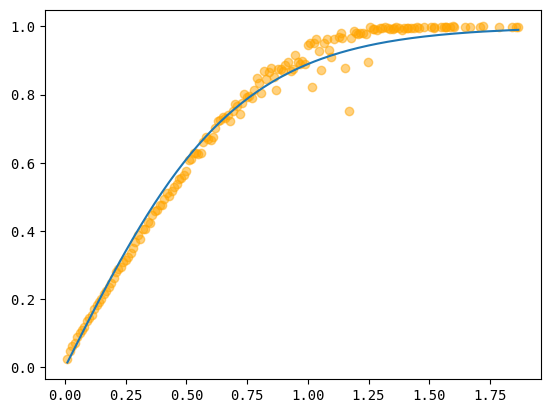

In [122]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(xdata, ydata, alpha=0.5, color='orange')
ax1.plot(xdata, func_y)
plt.show()

In [123]:
def sigmoid_d2(x, a): # second derivative of sigmoid function above
    return 2 * ((a**3*math.e**(2*-a*x)) /(1+math.e**(-a*x))**3 - (a**2 * math.e**(-a*x))/(1+math.e**(-a*x))**2)

d2y = calc_y(xdata, popt[0], sigmoid_d2)

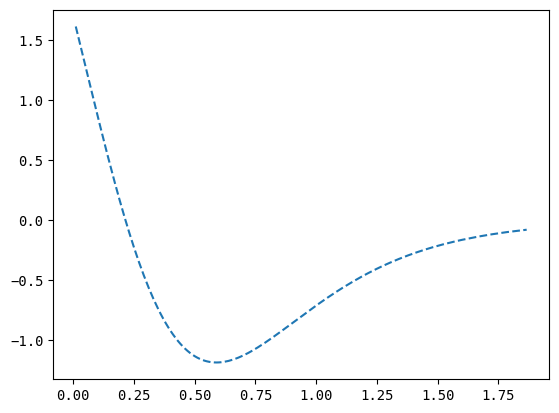

In [124]:
# plot second derivative of fitted sigmoid function (minimum of this function is the inflection point)
plt.plot(xdata, d2y, '--')

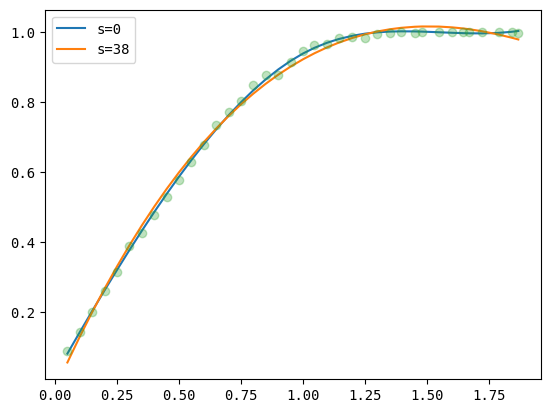

In [131]:
# fit and plot splines

tck = splrep(xdata, ydata, s=0.002)
tck_s = splrep(xdata, ydata, s=len(xdata))


plt.plot(xdata, BSpline(*tck)(xdata), '-', label='s=0')
plt.plot(xdata, BSpline(*tck_s)(xdata), '-', label=f's={len(xdata)}')
plt.plot(xdata, ydata, 'o', alpha=0.3)
plt.legend()
plt.show()

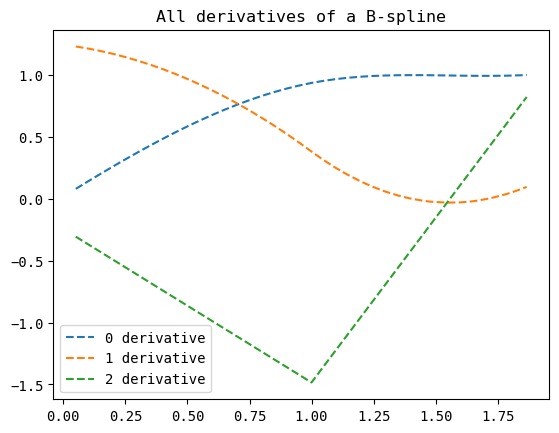

In [134]:
# second derivative of spline function
yders = interpolate.spalde(xdata, tck)
plt.figure()
for i in range(3):
   plt.plot(xdata, [d[i] for d in yders], '--', label=f"{i} derivative")
plt.legend()
#plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('All derivatives of a B-spline')
plt.show()

In [132]:
# function to plot relationship between total counts mean and percent detected value
# x: cell type specific total counts mean, y: cell type specific percent detected value 

def pl_tc_vs_pd(adata, ax, method='mean', return_df = False, layer='log_norm'):

    # calculate mean total counts per cell type
    subset_df = adata.to_df(layer='log_norm')
    means = adata.obs.groupby(['celltypist_cell_label']).mean()
    new_df = pd.DataFrame(data=means['total_counts']) #df with cell type as index and mean 'total_counts' as column

    temp = {}
    # calculate percentage of cells (per cell type) where each gene is detected (average)
    for cell_type in adata.obs['celltypist_cell_label'].unique():
        subset = subset_df[adata.obs['celltypist_cell_label'] == cell_type]
        nonzero_detected = pd.DataFrame(np.count_nonzero(subset, axis=0) / len(subset)*100, columns=[cell_type], index=subset.columns)
        if method=='median':
            temp[cell_type] = nonzero_detected[cell_type].median()
        else:
            temp[cell_type] = nonzero_detected[cell_type].mean()

    new_df['percent_detected'] = new_df.index.map(temp)
    new_df = new_df.sort_values(['total_counts'], ascending=True)
    if return_df:
        return new_df
    
    # plot new_df: x=total_counts, y=percent_detected
    for row, column in new_df.iterrows():
        ax.scatter(column['total_counts'], column['percent_detected'], c=np.random.rand(1, 3), label=row) 
        ax.annotate(row, (column['total_counts'], column['percent_detected']), (column['total_counts']+100, column['percent_detected']+0.1), fontsize=6.5)

    ax.set_title("Mean total counts vs. mean percent detected, per cell type")
    ax.set_xlabel("Mean total counts")
    ax.set_ylabel(str(method + " percent non-zero"))
    
    return ax

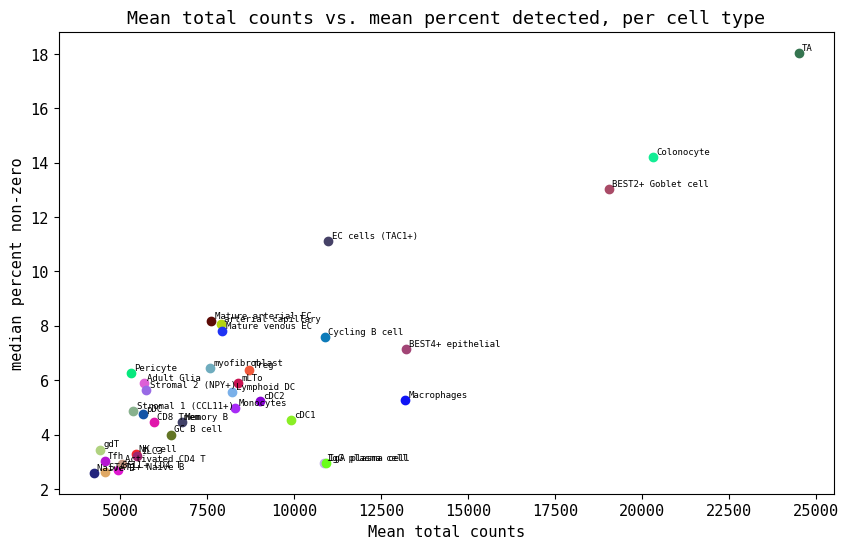

In [133]:
fig, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1 = pl_tc_vs_pd(adata, ax=ax1, method='median')
plt.show()
# TODO look online for cell size estimates for each cell type and compare to total counts? 

In [127]:
# function to plot histogram for given adata layer
def clean_data(adata, layer_name, threshold = 99.75, remove_zeros = False):
    df = adata.to_df(layer=layer_name)
    data = df.to_numpy().flatten()
    
    cutoff = np.percentile(df.values, threshold)
    if remove_zeros:
        data = data[data != 0]
    data = data[data <= cutoff]
    
    return data
    

def plot_hist(adata, ax, layer_name, bin_num=1000): # higher bin numbers made zeros in tc_norm_log disappear? 
    data = clean_data(adata, layer_name)
    
    hist, edges = np.histogram(data, bins=bin_num)

    ax.bar(edges[:-1], hist, width = max(edges)/bin_num, color='#0504aa', align='edge')
    ax.set_title(layer_name)
    ax.set_xlim(min(edges), np.percentile(data, 99.75))
    ax.set_ylim(0, np.percentile(hist, 99.75))
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlabel('Gene Expression')
    ax.set_ylabel('Frequency')
    ax.vlines(np.percentile(data, 97.5), ymin=0, ymax=max(hist), linestyle="--", color="r", label='97.5%')
        
    ax.legend()
    
    return ax

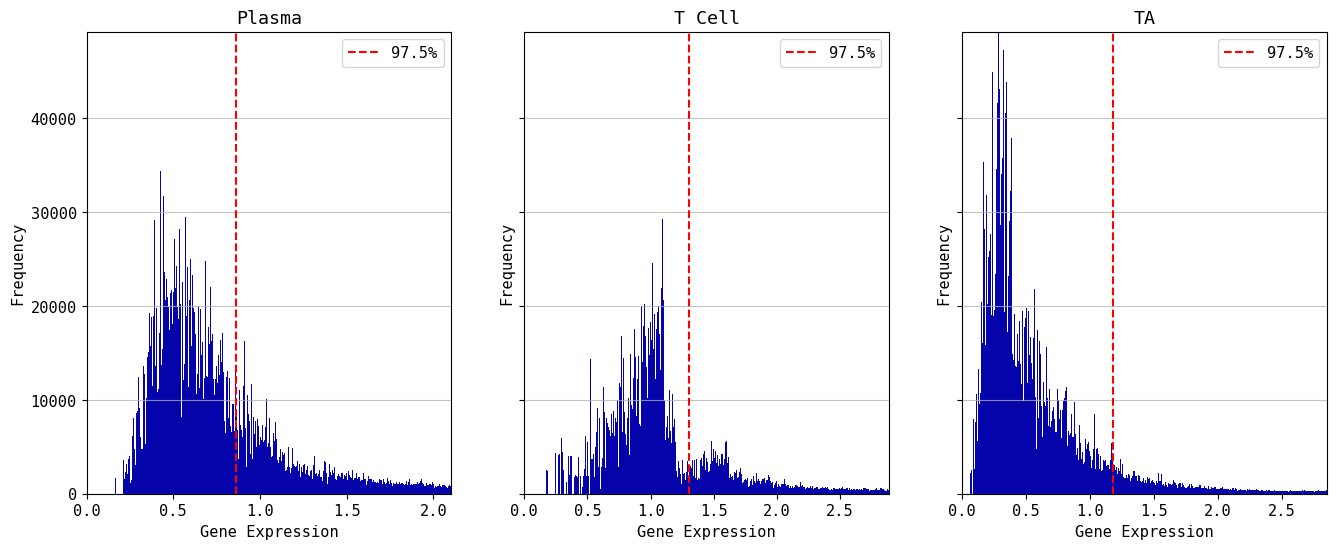

In [129]:
fig, (ax2, ax3, ax4) = plt.subplots(1,3, figsize=(16,6), sharey=True)
ax2 = plot_hist(adata[adata.obs['celltypist_cell_label_coarse'] == 'Plasma'], ax=ax2, layer_name='log_norm', bin_num=500)
ax2.set_title("Plasma")
ax3 = plot_hist(adata[adata.obs['celltypist_cell_label_coarse'] == 'T Cell'], ax=ax3, layer_name='log_norm', bin_num=500)
ax3.set_title("T Cell")
ax4 = plot_hist(adata[adata.obs['celltypist_cell_label'] == 'TA'], ax=ax4, layer_name='log_norm', bin_num=500)
ax4.set_title("TA")
plt.show()

In [91]:
# function to calculate the percent change between two layers (e.g. log_norm and magic)
def calculate_percent_change(adata, layer1, layer2, type='value'):
    df1 = adata.to_df(layer=layer1)
    df2 = adata.to_df(layer=layer2)
    
    nonzero_detected = pd.DataFrame(np.count_nonzero(df1, axis=0), columns=['df1_nonzero'], index=df1.columns)
    nonzero_detected['df2_nonzero'] = np.count_nonzero(df2, axis=0)
    if type == 'value':
        # calculate percent change of all values (including 0s)
        nonzero_detected['percent_change'] = (nonzero_detected['df2_nonzero'] - nonzero_detected['df1_nonzero']) / nonzero_detected['df1_nonzero'] * 100
    elif type=='nonzero':
        # calculate percentage of the number of values that changed from 0 to non-zero
        nonzero_detected['percent_change'] = (nonzero_detected['df2_nonzero'] - nonzero_detected['df1_nonzero']) / len(df1) * 100
    nonzero_detected['percent_change'] = nonzero_detected['percent_change'].fillna(0)
    return nonzero_detected

# function to plot the percent change between two layers (e.g. log_norm and magic)
def plot_percent_change(adata, layer1, layer2, cell_type, type='value', col='log1p(means)'):
    title=str(GOI)
    if cell_type != None:
        title = str("Overall expression in " + cell_type + " cells")
        if cell_type in adata.obs['celltypist_cell_label_coarse'].unique():
            adata = adata[adata.obs['celltypist_cell_label_coarse'] == cell_type]
        elif cell_type in adata.obs['celltypist_cell_label'].unique():
            adata = adata[adata.obs['celltypist_cell_label'] == cell_type]
        else:
            print("Cell type not found. Please check spelling.")
            return
    else:
        title = "All cell types"
        
    df = make_df(adata, col, layer=layer1)

    changes = calculate_percent_change(adata, layer1, layer2, type=type)
    df = df.join(changes, how='left').sort_values(['gene_num'], ascending=True)
        
    # plot mean expression of a gene (x) vs. percentage of cells where this gene is detected (y)
    ax = sns.scatterplot(data=df, x=col, y='percent_change', hue='expr_class', linewidth=0)
    ax.set_title(str(title + ": Expression vs. Change in Detection"))
    ax.legend(title='Expression Class', loc='lower left', bbox_to_anchor=(1, 0))
    plt.show()
    return ax